In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


In [2]:
df=pd.read_csv('5year.csv')
feature_names=pd.read_csv('feature-mapping.csv')
df.shape

(5910, 65)

In [3]:
columnList=feature_names.values.tolist()
column=[]
for item in columnList:
    column.append(item[0])
    
df.columns=column

#df.to_csv('data_with_heads.csv')

In [4]:
#Converting object values to float

feature_columns=[col for col in df.columns if col !="bankruptcy_label"]

for item in feature_columns:
    df[item]=df[item].astype('str')
    df[item]=df[item].apply(lambda x: x.replace('?', '0')).astype('float')

In [5]:
from sklearn.model_selection import train_test_split, StratifiedKFold,cross_validate

Y = df["bankruptcy_label"]
X = df.drop(["bankruptcy_label"], axis=1)

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, stratify=Y, random_state=0)

In [6]:
from sklearn.feature_selection import f_classif


F, pval = f_classif(X.fillna(0),Y)

pval_series = pd.Series(pval, index=X.columns)
pval_threshold = 0.01

best_features = pval_series[pval_series<pval_threshold].sort_values()
print(f"There are {len(best_features)} features with p-value less than {pval_threshold}: \n{best_features}")

There are 28 features with p-value less than 0.01: 
logarithm of total assets                                                                                             7.822699e-35
short-term liabilities / total assets                                                                                 1.045355e-25
working capital / total assets                                                                                        1.858383e-24
profit on sales / sales                                                                                               1.049347e-14
(sales - cost of products sold) / sales                                                                               2.004995e-11
(current liabilities * 365) / cost of products sold                                                                   3.654140e-10
total costs /total sales                                                                                              2.877801e-07
rotation receivables + inventor

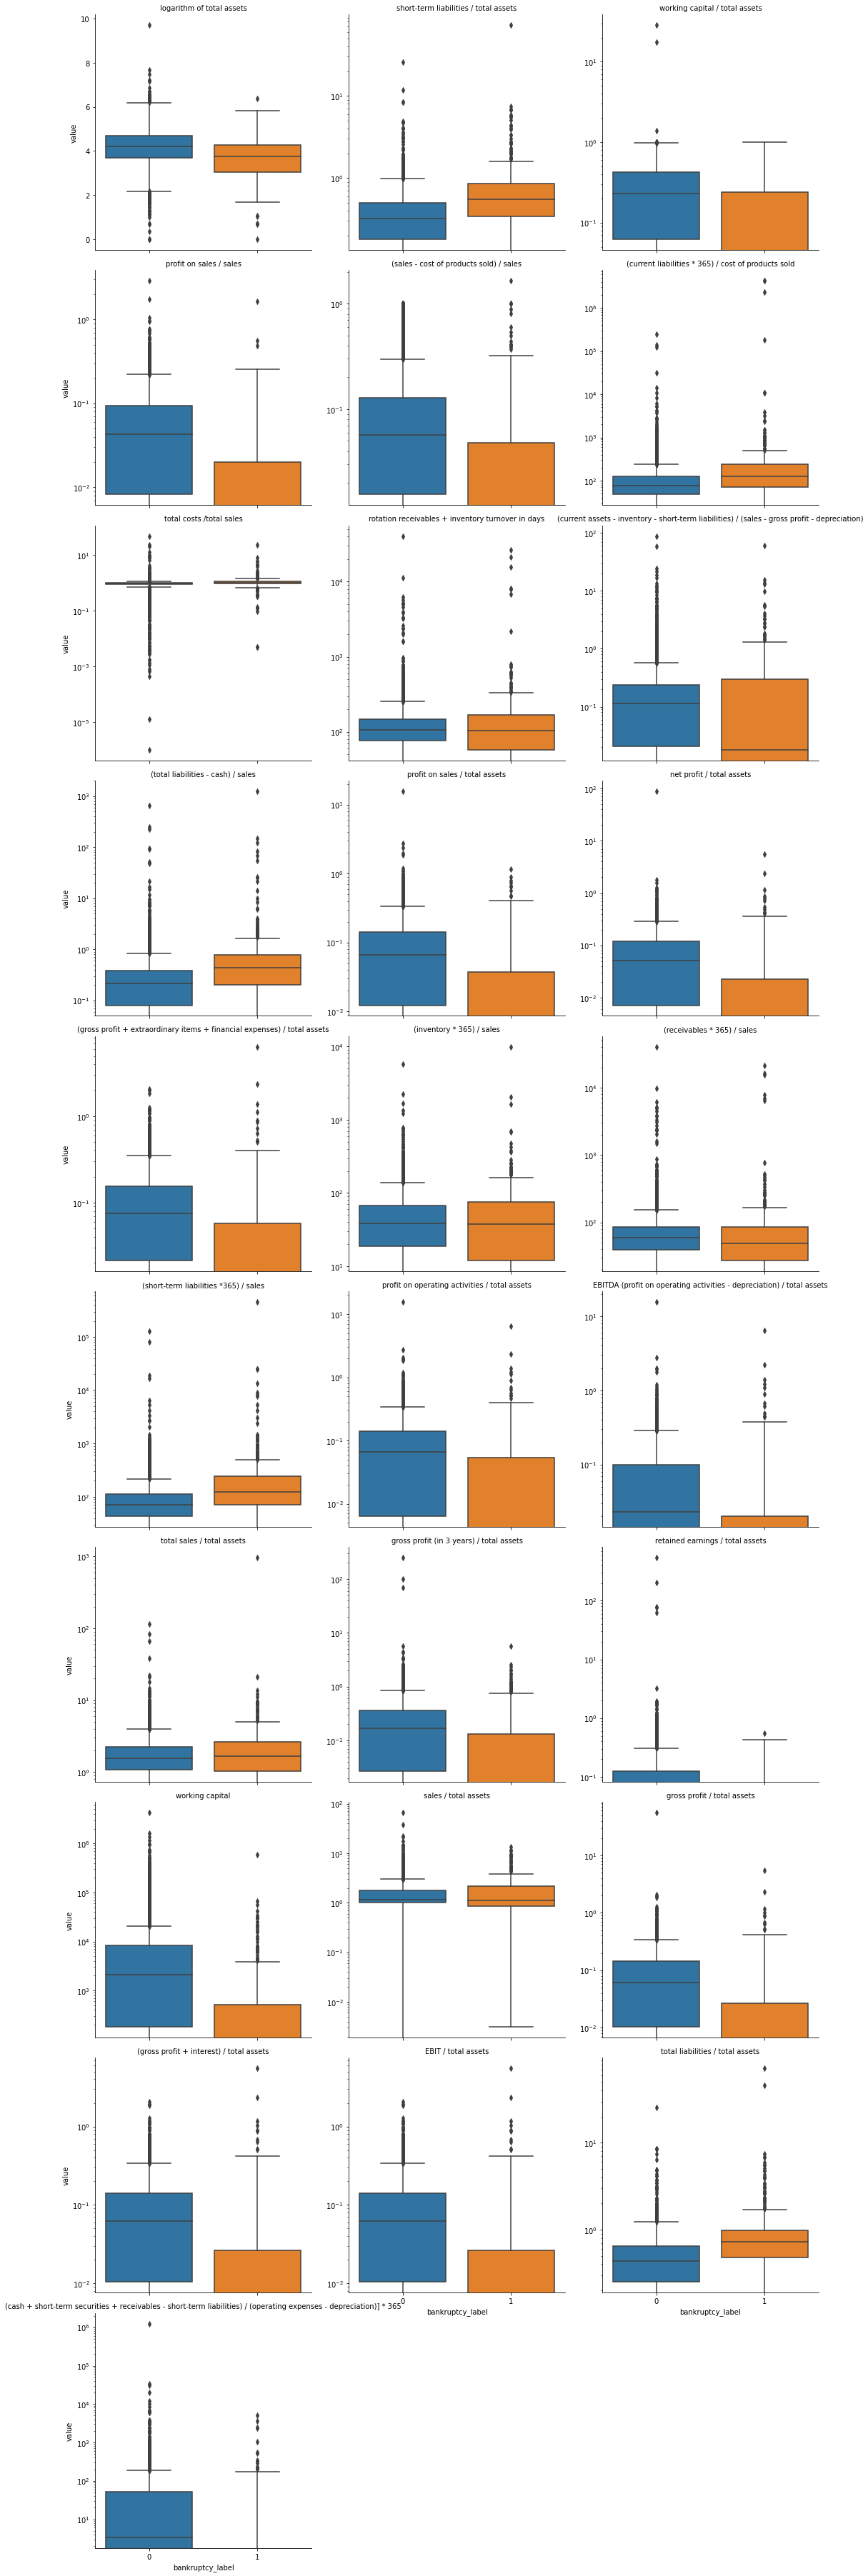

In [7]:

# melt the df to use seaborn function
cols = best_features.index.to_list() + ["bankruptcy_label"]
melted_df = df[cols].reset_index().melt(id_vars=["index", "bankruptcy_label"])

g = sns.catplot(data=melted_df, x="bankruptcy_label", y="value", col="variable", kind="box", col_wrap=3, sharey=False)
g.set_titles(col_template="{col_name}")

# plot in logarithmic scale as there are a few companies with extremely large values 
for ax in g.axes.flatten():
    if ax.get_title() != "logarithm of total assets":
        ax.set_yscale('log')

In [8]:
#making a new dataset with best features

df_with_best_features=df[cols]
df_with_best_features

,logarithm of total assets,short-term liabilities / total assets,working capital / total assets,profit on sales / sales,(sales - cost of products sold) / sales,(current liabilities * 365) / cost of products sold,total costs /total sales,rotation receivables + inventory turnover in days,(current assets - inventory - short-term liabilities) / (sales - gross profit - depreciation),(total liabilities - cash) / sales,...,gross profit (in 3 years) / total assets,retained earnings / total assets,working capital,sales / total assets,gross profit / total assets,(gross profit + interest) / total assets,EBIT / total assets,total liabilities / total assets,(cash + short-term securities + receivables - short-term liabilities) / (operating expenses - depreciation)] * 365,bankruptcy_label
0,6.1267,0.55407,0.011340,0.095457,0.080955,155.330,0.91905,127.300,0.275430,0.377880,...,0.41949,0.342040,15182.0000,1.08810,0.109490,0.109490,0.109490,0.55472,-66.5200,0
1,4.0022,0.38846,0.232980,-0.028591,-0.028591,108.050,1.00470,171.380,-0.012035,0.363810,...,0.00000,0.000000,2341.8000,1.27570,-0.006202,-0.006202,-0.006202,0.48465,6.1825,0
2,4.7622,0.22142,0.577510,0.129100,0.123960,81.653,0.87604,163.710,0.192290,0.050069,...,0.23566,0.187640,33401.0000,1.14150,0.162120,0.162120,0.162120,0.22142,120.0400,0
3,4.0153,0.51564,0.269270,0.010998,0.418840,253.910,0.59074,157.300,-0.796020,0.657790,...,0.00000,-0.073957,2789.6000,1.27540,-0.089951,-0.089951,-0.089951,0.88700,-55.9920,0
4,5.8823,0.44176,0.107650,0.240400,0.240400,140.120,0.77048,125.210,0.107160,0.363310,...,0.00000,0.000000,1.2437,1.51500,0.059280,0.059280,0.059280,0.55041,-22.9590,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5905,4.9667,0.22564,0.038857,0.020169,0.020169,50.128,1.01220,56.452,0.043904,0.418530,...,0.90184,0.000000,3599.1000,1.67680,0.013981,0.013981,0.013981,0.70621,-18.9070,1
5906,4.0622,0.95997,-0.800850,-0.123990,-0.064073,76.330,1.06410,11.451,1.482000,0.218640,...,-0.57805,-0.578050,-9242.1000,0.93979,-0.578050,-0.578050,-0.578050,0.96702,-67.3650,1
5907,5.3244,1.08460,-0.275990,0.092780,0.148880,244.230,0.85112,141.650,0.548240,0.658130,...,-0.15493,-0.179050,-58253.0000,1.17490,-0.154930,-0.154930,-0.154930,1.25530,-120.4400,1
5908,4.8555,0.17599,0.015449,-0.129340,-0.183200,70.252,1.18320,86.348,-1.167700,0.951810,...,-0.10918,-0.108860,1107.5000,0.84516,-0.109180,-0.109180,-0.109180,0.74394,-17.0030,1


In [9]:
feature_cols = [col for col in df_with_best_features.columns if col not in ("bankruptcy_label", "index")]

X = df[feature_cols].fillna(0)
y = df["bankruptcy_label"]

In [10]:
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_validate

# first level train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=0)

print(f"Positive class samples in train set: {np.bincount(y_train)[1]}")
print(f"Positive class samples in test set: {np.bincount(y_test)[1]} \n")

# 3-fold cross validation
stratified_cv = StratifiedKFold(n_splits=3)
for (train, validation) , sequence in zip(stratified_cv.split(X_train, y_train), ("first", "second", "third")):
    print(f"Positive class samples in {sequence} validation fold: {np.bincount(y_train.iloc[validation])[1]}")

Positive class samples in train set: 328
Positive class samples in test set: 82 

Positive class samples in first validation fold: 109
Positive class samples in second validation fold: 109
Positive class samples in third validation fold: 110


In [11]:
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler

print(f"Before resampling: \n{y_train.value_counts()}")

ros = RandomOverSampler(random_state=0)
X_ros, y_ros = ros.fit_resample(X_train, y_train)
print(f"\nAfter oversampling: \n{y_ros.value_counts()}")

rus = RandomUnderSampler(random_state=0)
X_rus, y_rus = rus.fit_resample(X_train, y_train)
print(f"\nAfter undersampling: \n{y_rus.value_counts()}")

Before resampling: 
0    4400
1     328
Name: bankruptcy_label, dtype: int64

After oversampling: 
1    4400
0    4400
Name: bankruptcy_label, dtype: int64

After undersampling: 
1    328
0    328
Name: bankruptcy_label, dtype: int64


In [12]:
from sklearn.metrics import fbeta_score, make_scorer
from imblearn.pipeline import Pipeline
from sklearn.preprocessing import RobustScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

def evaluate_pipeline(pipeline, X_train, y_train, cv):
    """
    Run cross validation for the input pipeline and returns the average precision, recall and F-beta score.
    """
    cv_metrics = cross_validate(pipeline, X_train, y_train, cv=cv, scoring={"precision":"precision", "recall":"recall", "fbeta":make_scorer(fbeta_score, beta=2)})
    cv_metrics_df = pd.DataFrame(cv_metrics)
    average_cv_metrics = cv_metrics_df[["test_precision", "test_recall", "test_fbeta"]].mean()
    return average_cv_metrics

scaler = RobustScaler()
classifier = LogisticRegression(random_state=0, solver='newton-cg', max_iter=200)
rf = RandomForestClassifier(n_estimators=200)

# oversampling
oversampling_pipeline = Pipeline([('ros', ros), ('scaler', scaler), ("classifier", classifier)])
oversampling_metrics = evaluate_pipeline(oversampling_pipeline, X_train, y_train, stratified_cv)
print(f"Metrics with random oversampling: \n{oversampling_metrics}\n")

# undersampling
undersampling_pipeline = Pipeline([('rus', rus), ('scaler', scaler), ("classifier", classifier)])
undersampling_metrics = evaluate_pipeline(undersampling_pipeline, X_train, y_train, stratified_cv)
print(f"Metrics with random undersampling: \n{undersampling_metrics}")

Metrics with random oversampling: 
test_precision    0.256383
test_recall       0.707200
test_fbeta        0.523194
dtype: float64

Metrics with random undersampling: 
test_precision    0.223818
test_recall       0.713233
test_fbeta        0.495818
dtype: float64


<AxesSubplot:title={'center':'Learning Curve'}, xlabel='Training examples', ylabel='Score'>

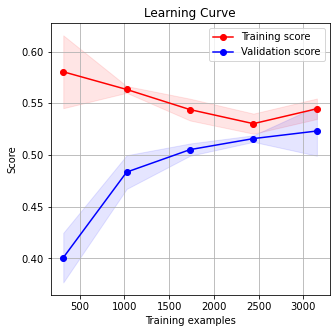

In [13]:

from diagnosis import plot_learning_curve

# since this will is a 2D plot, we will only plot a metric (F-beta score) on the y-axis
plot_learning_curve(oversampling_pipeline, X_train, y_train, stratified_cv, make_scorer(fbeta_score, beta=2))

<AxesSubplot:title={'center':'Validation Curve'}, xlabel='classifier__C', ylabel='Score'>

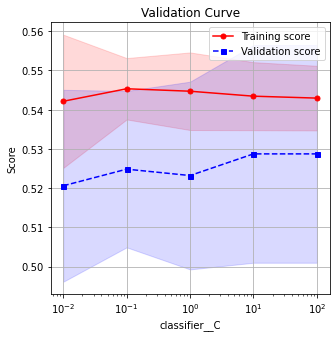

In [14]:
from diagnosis import plot_validation_curve

param_name="classifier__C"
param_range=[0.01, 0.1, 1, 10, 100]

plot_validation_curve(oversampling_pipeline, X_train, y_train, stratified_cv, make_scorer(fbeta_score, beta=2), param_name, param_range, log_scale=True)

In [15]:
from sklearn.metrics import confusion_matrix
import itertools
import matplotlib
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline  
import numpy as np

In [16]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)
    
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

In [20]:
oversampling_pipeline.fit(X_train,y_train)
y_prediction=oversampling_pipeline.predict(X_test)

Confusion matrix, without normalization
[[924 176]
 [ 23  59]]


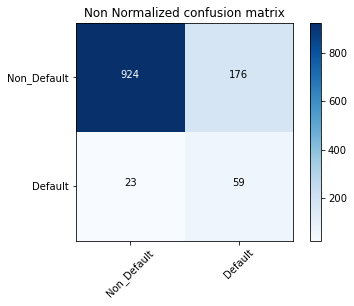

In [21]:
cnf_matrix = confusion_matrix(y_test, y_prediction)
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=['Non_Default', 'Default'], normalize=False,
                      title='Non Normalized confusion matrix')

Normalized confusion matrix
[[0.84      0.16     ]
 [0.2804878 0.7195122]]


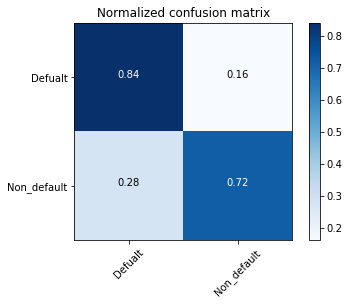

In [22]:
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=['Defualt', 'Non_default'], normalize=True,
                      title='Normalized confusion matrix')

In [23]:
from sklearn.metrics import classification_report

In [24]:
print(classification_report(y_test, y_prediction,target_names=["non_default", "default"]))

              precision    recall  f1-score   support

 non_default       0.98      0.84      0.90      1100
     default       0.25      0.72      0.37        82

    accuracy                           0.83      1182
   macro avg       0.61      0.78      0.64      1182
weighted avg       0.93      0.83      0.87      1182

